# Setup

In [1]:
import dataloader
import torch
import numpy as np
import argparse
import importlib

In [2]:
# Arguments ===================================
parser = argparse.ArgumentParser()

parser.add_argument('--gpu_id', type=int, default=0)
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--config', type=str, default='config.yml')
parser.add_argument('--dataset', type=str, default='BlogCatalog', choices=['cora', 'BlogCatalog', 'chameleon'])
parser.add_argument('--g0_method', type=str, default='random', choices=[
  'random', # randomly distribution of g0
  'bias', # a random class has a 3x higher likelihood of being in g0
  'large_cluster', # a random node and [g0_size] of its neighbors are in g0
  'many_clusters', # 10 random nodes and [g0_size] of their neighbors are in g0
  ])
parser.add_argument('--switch', type=bool, default=True)
parser.add_argument('--nolabeltask', type=bool, default=True)

parser.add_argument('--g0_size', type=float, default=0.1)
parser.add_argument('--attack_method', type=str, default='sll_no_g', choices=[
  'sll', # Selective Learnability Lock
  'sll_no_g', # Disable gradient guidance
  'noise', # Noise protection
  'heuristic', # Heuristic protection
  'edge_reconstruction' # Edge Reconstructions
  ])
parser.add_argument('--budget_pct', type=float, default=0.25)
parser.add_argument('--attack_epochs', type=int, default=30)
parser.add_argument('--save_results', type=str, default='Y', choices=['N', 'Y'])
parser.add_argument('--save_graph', type=str, default='N', choices=['N', 'Y'])

args = parser.parse_args("")

if args.gpu_id >= 0:
  device = torch.device(f'cuda:{args.gpu_id}' if torch.cuda.is_available() else 'cpu')
else:
  device = torch.device('cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

import yaml
from yaml import SafeLoader
config = yaml.load(open(args.config), Loader=SafeLoader)[args.dataset]

In [3]:
import dgl
import numpy as np
import loadSNAP
import importlib
import utils
importlib.reload(loadSNAP)
importlib.reload(utils)

# Load graph ===================================
if args.dataset in ["chameleon"]:

    graph = dgl.from_networkx(loadSNAP.load_graph("chameleon/musae_chameleon_edges.csv"))

    # Load labels
    labels = torch.tensor(loadSNAP.load_labels("chameleon/musae_chameleon_target.csv"))
    labels = utils.discretize(labels, 5)

    graph.ndata['label'] = labels
    labels = labels.to(device)

    # Load feats
    rawFeat = loadSNAP.load_features("chameleon/musae_chameleon_features.json")
    feat = torch.zeros((graph.num_nodes(), 4000))
    for key in rawFeat:
        feat[key] = utils.idx_to_bool(torch.tensor(rawFeat[key]), 4000)
    graph.ndata['feat'] = feat
    feat = feat.to(device)

    # Train test split
    train_mask = torch.bernoulli(torch.full([graph.num_nodes()], 0.3)).bool()
    graph.ndata['train_mask'] = train_mask
    graph.ndata['test_mask'] = ~train_mask
    adj = graph.adj().to_dense()

else:
    graph = dataloader.load_DGL(args.dataset)
    feat = graph.ndata['feat'].to(device)
    labels = graph.ndata['label'].to(device)
    adj = graph.adj().to_dense()

H = utils.calc_homophily(adj, labels)
print(f'H: {H:.2%}')

H: 40.11%


(array([2828.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2368.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

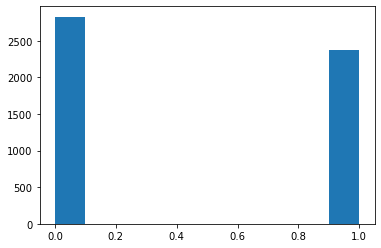

In [4]:
# Select features
# TOP 10 cora: [1263, 1301, 1138, 19, 135, 1336, 495, 99, 1123],
# TOP 10 chameleon: [1794, 2753,  528,  598,  415, 2297,  735,   73, 2408, 2539],
# TOP 10 blogcatalog: [6, 10,  9,  7, 17, 18]
import scipy
num_tasks = 2
tasks = torch.zeros((num_tasks, feat.shape[0]), dtype=torch.int64).to(device)

tasks[0] = labels
doMedian = False
if args.dataset == 'cora':
    feat1 = 1263
    feat2 = 1301
    doMedian = True
elif args.dataset == 'chameleon':
    feat1 = 1794
    feat2 = 2753
elif args.dataset == 'BlogCatalog':
    feat1 = 6
    feat2 = 10

if args.nolabeltask:
    if doMedian:
        med = feat[:, feat2].median()
        tasks[0] = (feat[:, feat2] > med).long()
    else:
        tasks[0] = feat[:, feat2]
    feat[:, feat2] = 0

if doMedian:
    med = feat[:, feat1].median()
    tasks[1] = (feat[:, feat1] > med).long()
else:
    tasks[1] = feat[:, feat1]
feat[:, feat1] = 0

if args.switch:
    temp = tasks[0].clone()
    tasks[0] = tasks[1].clone()
    tasks[1] = temp

tasks = tasks.to(device)

import matplotlib.pyplot as plt
plt.hist(tasks[1].cpu().numpy())

In [5]:
# Designate g0 ===================================
g0_size = int(args.g0_size * graph.num_nodes())

def get_clusters(num_roots: int, max_hops: int, target_size: int) -> torch.tensor:
  root_nodes = torch.rand(graph.num_nodes()).topk(num_roots).indices

  for hop in range(max_hops):
    newNodes = adj[root_nodes].nonzero().t()[1]
    root_nodes = torch.cat((root_nodes, newNodes))
    root_nodes = torch.unique(root_nodes)
    if root_nodes.shape[0] >= target_size:
      break

  g0 = torch.zeros(graph.num_nodes())
  g0[root_nodes[:target_size]] = 1
  g0 = g0.bool()
  return g0

if args.g0_method == 'many_clusters': # 10 nodes and their neighbors
  g0 = get_clusters(10, 10, g0_size)
elif args.g0_method == 'large_cluster': # 1 node and its neighbors
  g0 = get_clusters(1, 10, g0_size)
elif args.g0_method == 'random': # g0 is random/bias
  g0_probs = torch.ones(graph.num_nodes())
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()
elif args.g0_method == 'bias': # g0 is skewed toward a class by factor of 3
  bias = torch.randint(0, labels.max() + 1, [1]).item()
  print(f'G0 class bias: {bias}')
  g0_probs = torch.ones(graph.num_nodes())
  g0_probs[labels == bias] = 3
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()

print(f'G0 size: {g0.sum().item()}')
print(f'G0 pct: {g0.sum().item() / graph.num_nodes():.2%}')

g0 = g0.cpu()
gX = ~g0

G0 size: 550
G0 pct: 10.59%


# Do Attack

In [6]:
# Perform attack ==========================

import utils
import models
import torch.nn.functional as F
from tqdm import tqdm


num_perturbations = (graph.num_edges()) * args.budget_pct

print(f'Attacking with method: {args.attack_method}')

if args.attack_method == 'heuristic':
  locked_adj = adj.clone()
  locked_adj[:, g0] = 0
  locked_adj[g0, :] = 0
elif args.attack_method == 'noise':
  noise = torch.zeros_like(adj)
  noise[g0, :] = 1
  noise[:, gX] = 0
  noise *= 2 * num_perturbations / noise.sum()
  noise = torch.bernoulli(noise.clamp(0, 1))
  noise = utils.make_symmetric(noise)
  locked_adj = utils.get_modified_adj(adj, noise)
elif args.attack_method == 'sll_no_g':
  import scipy
  factor_s = 1 / scipy.stats.entropy(tasks[0].cpu().numpy())
  factor_u = 1 / scipy.stats.entropy(tasks[1].cpu().numpy())
  factor_avg = (factor_s + factor_u) / 2
  factor_s /= factor_avg
  factor_u /= factor_avg

  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  surrogates = []
  for task in tasks:
    surrogates.append(models.DenseGCN(
      in_size=feat.shape[1],
      out_size=int(task.max().item())+1,
      hid_size=config['hid_size'],
      lr=config['lr'],
      dropout=config['dropout'],
      weight_decay=config['weight_decay']
  ).to(device))

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL (no gradient guidance)")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).requires_grad_(True).float().to(device)

    # Get grad of modified adj w.r.t attack loss
    loss = 0
    for i, surrogate in enumerate(surrogates):
      pred = surrogate(feat, modified_adj)

      if i == 0:
        loss += factor_s * (F.cross_entropy(pred[g0], tasks[0][g0]) \
            - F.cross_entropy(pred[gX], tasks[0][gX]))
      else:
        loss += - factor_u * F.cross_entropy(pred, tasks[i])

    adj_grad = torch.autograd.grad(loss, modified_adj)[0].cpu()

    # Update perturbations
    lr = (config['sll_no_g_lr']) / ((epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the surrogate
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    model_loss = 0

    for i, surrogate in enumerate(surrogates):
       model_loss += surrogate.fit(feat, modified_adj, tasks[i].to(device), epochs=1, verbose=False)

    t.set_postfix({"adj_l": loss.item(),
                    "adj_g": (adj_grad.sum().item()),
                    "pre-p": pre_projection,
                    "target": int(num_perturbations),
                    "model_loss": model_loss})
elif args.attack_method == 'sll':
  labels = tasks[0].to(device)
  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Initialize sampling matrix
  import sampling_matrix
  samplingMatrix = sampling_matrix.SamplingMatrix(
    g0=g0, gX=gX, adj=adj, sample_size=config['sll_sample_size'])
  count = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  surrogate = models.DenseGCN(
      in_size=feat.shape[1],
      out_size=labels.max().item()+1,
      hid_size=config['hid_size'],
      lr=config['lr'],
      dropout=config['dropout'],
      weight_decay=config['weight_decay']
  ).to(device)

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).float().to(device)

    for sample_epoch in range(config['sll_num_samples']): 
      # Get sample indices
      idx = samplingMatrix.get_sample()

      # Map sample to adj
      sample = modified_adj[idx[0], idx[1]].clone().detach().requires_grad_(True).to(device)
      modified_adj[idx[0], idx[1]] = sample

      # Get grad
      pred = surrogate(feat, modified_adj)
      loss = F.cross_entropy(pred[g0], labels[g0]) \
          - F.cross_entropy(pred[gX], labels[gX])

      grad = torch.autograd.grad(loss, sample)[0]

      # Implement averaging of duplicate samples
      adj_grad[idx[0], idx[1]] += grad.cpu()
      count[idx[0], idx[1]] += 1

    # Update the sampling matrix
    samplingMatrix.updateByGrad(adj_grad, count)

    # Average the gradient
    adj_grad = torch.div(adj_grad, count)
    adj_grad[adj_grad != adj_grad] = 0
    
    # Update perturbations
    lr = (config['sll_lr']) / ((epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the model
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    model_loss = surrogate.fit(feat, modified_adj, labels, epochs=1, verbose=False)

    t.set_postfix({"attack_loss": loss.item(),
                    # "adj_g": (adj_grad.sum().item()),
                    "pre-projection": pre_projection,
                    "target": int(num_perturbations),
                    "surrogate_loss": model_loss})
elif args.attack_method == 'edge_reconstruction':
  task0same = tasks[0].repeat(tasks[0].shape[0], 1)
  task0same = (task0same == task0same.t()).long()
  task0same[g0, :][:, g0] = 1 - task0same[g0, :][:, g0]
  task0same.fill_diagonal_(0)

  task1same = tasks[1].repeat(tasks[0].shape[0], 1)
  task1same = (task1same == task1same.t()).long()
  task1same.fill_diagonal_(0)

  possibleEdges = task0same * task1same
  possibleEdges[:, g0][gX, :] = 0
  possibleEdges[:, gX][g0, :] = 0
  possibleEdges = possibleEdges * (graph.num_edges() / possibleEdges.sum())
  locked_adj = torch.bernoulli(possibleEdges).cpu()

# Discretize the best locked_adj ============
if args.attack_method in ['sll', 'sll_no_g']:
  locked_adj = None
  with torch.no_grad():
    max_loss = -1000
    for k in range(0,3):
        sample = torch.bernoulli(perturbations)
        modified_adj = utils.get_modified_adj(adj, sample)
        modified_adj = utils.make_symmetric(modified_adj) 

        loss = 0
        for i, surrogate in enumerate(surrogates):
          pred = surrogate(feat, modified_adj.to(device))

          if i == 0:
            loss += F.cross_entropy(pred[g0], tasks[0][g0]) \
                - F.cross_entropy(pred[gX], tasks[0][gX])
          else:
            loss += - F.cross_entropy(pred, tasks[i])

        if loss > max_loss:
            max_loss = loss
            locked_adj = modified_adj
    
    print(f"Best sample loss: {max_loss:.2f}")

diff = adj - locked_adj
print(f'Edges modified: {diff.abs().sum() / 2:.0f}')

Attacking with method: sll_no_g


SLL (no gradient guidance): 100%|██████████| 30/30 [00:07<00:00,  4.02it/s, adj_l=-.235, adj_g=-76, pre-p=42304, target=85871, model_loss=2.16]  


Best sample loss: -0.80
Edges modified: 17575


# Eval

In [7]:
factor_s = 1 / scipy.stats.entropy(tasks[0].cpu().numpy())
factor_u = 1 / scipy.stats.entropy(tasks[1].cpu().numpy())
factor_avg = (factor_s + factor_u) / 2
factor_s /= factor_avg
factor_u /= factor_avg
factor_s, factor_u

(0.986759684315447, 1.013240315684553)

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [9]:
gX_train = torch.logical_and(gX, graph.ndata['train_mask'])
gX_test = torch.logical_and(gX, graph.ndata['test_mask'])
g0_test = torch.logical_and(g0, graph.ndata['test_mask'])

def get_emb(test_adj: torch.tensor, task):
    model = models.DenseGCN(
        in_size=feat.shape[1],
        out_size=int(task.max().item())+1,
        hid_size=config['hid_size'],
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)

    model.fit(feat, test_adj, task, epochs=100, mask=gX_train)
    
    pred = model(feat, test_adj).cpu()

    acc_gX = utils.eval_acc(model, feat, test_adj, task, gX_test)
    acc_g0 = utils.eval_acc(model, feat, test_adj, task, g0_test)

    return pred, acc_g0, acc_gX



In [10]:
print(f"{args.dataset} @ {args.attack_method}", end=" ")
labs = ['taskA', 'taskB']
if args.nolabeltask: labs[0] = 'taskC'
if args.switch: labs = labs[::-1]
print("| TASKS: " + (", ".join(labs)))

BlogCatalog @ sll_no_g | TASKS: taskB, taskC


In [11]:
a = []

for i, task in enumerate(tasks):
  # Base
  base_pred, base_acc_g0, base_acc_gX = get_emb(adj, task)

  lock_pred, lock_acc_g0, lock_acc_gX = get_emb(locked_adj, task)

  a.append([
    (lock_acc_g0 - base_acc_g0) / base_acc_g0,
    (lock_acc_gX - base_acc_gX) / base_acc_gX,
  ])

GCN Training: 100%|██████████| 100/100 [00:05<00:00, 19.14it/s, loss=0.5]


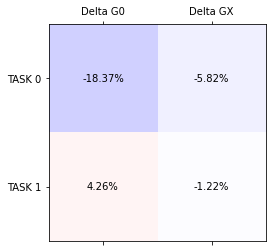

In [12]:
fig, ax = plt.subplots()
ax.matshow(a, vmin=-1, vmax=1, cmap='bwr')
ax.set_xticklabels([''] + ['Delta G0', 'Delta GX'])
ax.set_yticklabels([''] + ['TASK 0', 'TASK 1'])
# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f'{a[i][j]:.2%}',
                       ha="center", va="center", color="black")

In [13]:
a

[[-0.18367345765797813, -0.0582329031183401],
 [0.042553188656184855, -0.012195127240348953]]

In [14]:
# Save the results
import export
import FeatureMetrics

results = {
  'dataset': args.dataset,
  'seed': args.seed,
  'config': args.config,
  'g0_method': args.g0_method,
  'g0_size': args.g0_size,
  'attack_epochs': args.attack_epochs,
  'attack_method': args.attack_method,
  'budget_pct': args.budget_pct,
  'lr': config['sll_no_g_lr'],
  's': labs[0],
  'u': labs[1],
  'H0_s': utils.calc_homophily(adj, tasks[0]),
  'H1_s': utils.calc_homophily(locked_adj, tasks[0]),
  'H0_u': utils.calc_homophily(adj, tasks[1]),
  'H1_u': utils.calc_homophily(locked_adj, tasks[1]),
  'MI': FeatureMetrics.mutual_information(tasks[0], tasks[1]),
  'dacc_s_g0': a[0][0],
  'dacc_s_gX': a[0][1],
  'dacc_u_g0': a[1][0],
  'dacc_u_gX': a[1][1],
  'e': - a[0][0] + a[0][1] + a[1][0] + a[1][1],
  'edges_modified': int(diff.abs().sum() / 2),
  'classes_s': int(tasks[0].max().item()+1),
  'classes_u': int(tasks[1].max().item()+1),
  'num_edges': int(graph.num_edges()),
  'num_nodes': graph.num_nodes(),
}
results

{'dataset': 'BlogCatalog',
 'seed': 123,
 'config': 'config.yml',
 'g0_method': 'random',
 'g0_size': 0.1,
 'attack_epochs': 30,
 'attack_method': 'sll_no_g',
 'budget_pct': 0.25,
 'lr': 500,
 's': 'taskB',
 'u': 'taskC',
 'H0_s': 0.5369360032141048,
 'H1_s': 0.5313948075580288,
 'H0_u': 0.5117006224416716,
 'H1_u': 0.5103573771185544,
 'MI': 0.002825789153575897,
 'dacc_s_g0': -0.18367345765797813,
 'dacc_s_gX': -0.0582329031183401,
 'dacc_u_g0': 0.042553188656184855,
 'dacc_u_gX': -0.012195127240348953,
 'e': 0.15579861595547392,
 'edges_modified': 17575,
 'classes_s': 2,
 'classes_u': 2,
 'num_edges': 343486,
 'num_nodes': 5196}

In [15]:
export.saveData('./results1.csv', results)

Error: Column mismatch (orig_edges in csv but not in data to append)


False